In [38]:
import os
import numpy as np
from pymongo.mongo_client import MongoClient
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [39]:
#Setup Database
load_dotenv()
uri = os.environ['DB_URI']
client = MongoClient(uri)
db = client["rosen"]
collection = db["big_data_2"]

In [162]:
# configuration = region
#configuration = "Europe"
documents = collection.find({}, {"_id": 1, "instrument": 1, "configuration": 1, "wall_thickness": 1, "magnetization": 1, "timestamp": 1, "velocity": 1})
files = pd.DataFrame(list(documents))

In [163]:
def sin_func(x, A, B, C, D):
    return A * np.sin(B * x + C) + D
def quad_func(x, A, B, C):
    return A * x**2 + B * x + C
def abs_func(x, a, h, b):
    return a * np.abs(x - h) + b
def cubic_func(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d
def sqrt_func(x, a, h, k):
    with np.errstate(invalid='ignore'):
        return a * np.sqrt(x - h) + k
def lin_func(x, a, b):
    return a * x + b

In [164]:
def zscore_create_outliers_mask(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = np.abs((data - mean) / std)  # Berechne den absoluten Z-Score für jeden Datenpunkt
    return z_scores < threshold  # True für Datenpunkte innerhalb des Schwellenwerts, False für Ausreißer

def iqr_create_outliers_mask(data, k=1.5):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    return (data >= lower_bound) & (data <= upper_bound)

def std_create_outliers_mask(data, threshold = 1.5):
    mean = np.mean(data)
    std_dev = np.std(data)
    distance_from_mean = np.abs(data - mean) / std_dev
    mask = distance_from_mean < threshold
    return mask

In [165]:
def prepare_data(row, preview_plots=False):
    mask = ~np.isnan(row['magnetization'])
    clean_wall_thickness = np.array(row['wall_thickness'])[mask]
    clean_magnetization = np.array(row['magnetization'])[mask]
    clean_timestamp = np.array(row["timestamp"])[mask]
    clean_velocity = np.array(row["velocity"])[mask]
 
    mask2 = clean_wall_thickness > 0
    clean_wall_thickness = clean_wall_thickness[mask2]
    clean_magnetization = clean_magnetization[mask2]
    clean_timestamp = clean_timestamp[mask2]
    clean_velocity = clean_velocity[mask2]
    
    mask3 = clean_wall_thickness < 40
    clean_wall_thickness = clean_wall_thickness[mask3]
    clean_magnetization = clean_magnetization[mask3]
    clean_timestamp = clean_timestamp[mask3]
    clean_velocity = clean_velocity[mask3]
    
    if clean_magnetization.size > 0:
        #zscore remove outliers
        iqr_k = 0.75
        outliers_wt = zscore_create_outliers_mask(clean_wall_thickness) & iqr_create_outliers_mask(clean_wall_thickness, iqr_k) & std_create_outliers_mask(clean_wall_thickness)
        outliers_m = zscore_create_outliers_mask(clean_magnetization) & iqr_create_outliers_mask(clean_magnetization, iqr_k) & std_create_outliers_mask(clean_magnetization)
        outliers_t = zscore_create_outliers_mask(clean_timestamp) & iqr_create_outliers_mask(clean_timestamp, iqr_k) & std_create_outliers_mask(clean_timestamp)
        outliers_v = zscore_create_outliers_mask(clean_velocity) & iqr_create_outliers_mask(clean_velocity, iqr_k) & std_create_outliers_mask(clean_velocity)
        clean_magnetization = clean_magnetization[outliers_wt & outliers_m & outliers_t & outliers_v]
        clean_wall_thickness = clean_wall_thickness[outliers_wt & outliers_m & outliers_t & outliers_v]
        clean_timestamp = clean_timestamp[outliers_wt & outliers_m & outliers_t & outliers_v]
        clean_velocity = clean_velocity[outliers_wt & outliers_m & outliers_t & outliers_v]
    
    
    if clean_magnetization.size > 0:
        
        model = LinearRegression()
        X = clean_timestamp.reshape(-1, 1)
        y = clean_magnetization
        
        model.fit(X, y)
        prediction = model.predict(X)
        old_mean = clean_magnetization[0:5].mean()
        
        if (old_mean > 100 or old_mean < -100):
            print("mean error!!")
        
        clean_magnetization -= prediction

        
        #detrend(data=clean_magnetization, overwrite_data=True)
        #add mean to offset linear regression
        clean_magnetization += old_mean
        #keep negative values
        #clean_magnetization += np.abs(clean_magnetization.min())

    if preview_plots:    
        plt.subplot()
        plt.plot(clean_timestamp, clean_magnetization)
        plt.show()
        
        plt.subplot()
        plt.scatter(clean_wall_thickness, clean_magnetization)
        plt.xlim(0, 40)
        plt.ylim(-40, 40)
        
        #plt.subplot()
        #plt.scatter(clean_timestamp, clean_velocity)
    
        plt.show()
    
    cluster_centers = [[-1,.1],]
    if clean_magnetization.size > 0:
        #get best cluster count
        data = np.vstack((clean_wall_thickness, clean_magnetization)).T  
        
        #test 2 clusters
        k = 2
        kmeans = KMeans(n_clusters=2, random_state=42).fit(data)
        cluster_labels = kmeans.labels_
        cluster_centers = kmeans.cluster_centers_
        silhouette_avg = silhouette_score(data, cluster_labels)
        
        if silhouette_avg < 0.5:
            #use one cluster
            k = 1
            kmeans = KMeans(n_clusters=1, random_state=42).fit(data)
            cluster_centers = kmeans.cluster_centers_
            cluster_labels = kmeans.labels_
        if preview_plots:
            display(f"k count is {k}, score from 2 was {silhouette_avg}")

   # row["centers"] = cluster_centers
    if clean_velocity.size > 0:
        avg_vel = clean_velocity.mean()
        temp = np.full((np.array(cluster_centers).shape[0], 1), avg_vel)
        temp = np.hstack((cluster_centers, temp))
        row["centers"] = temp
    else:
        row["centers"] = np.empty((np.array(cluster_centers).shape[0], 3))
 
    row["magnetization"] = clean_magnetization
    row["wall_thickness"] = clean_wall_thickness
    row["velocity"] = clean_velocity
    return row

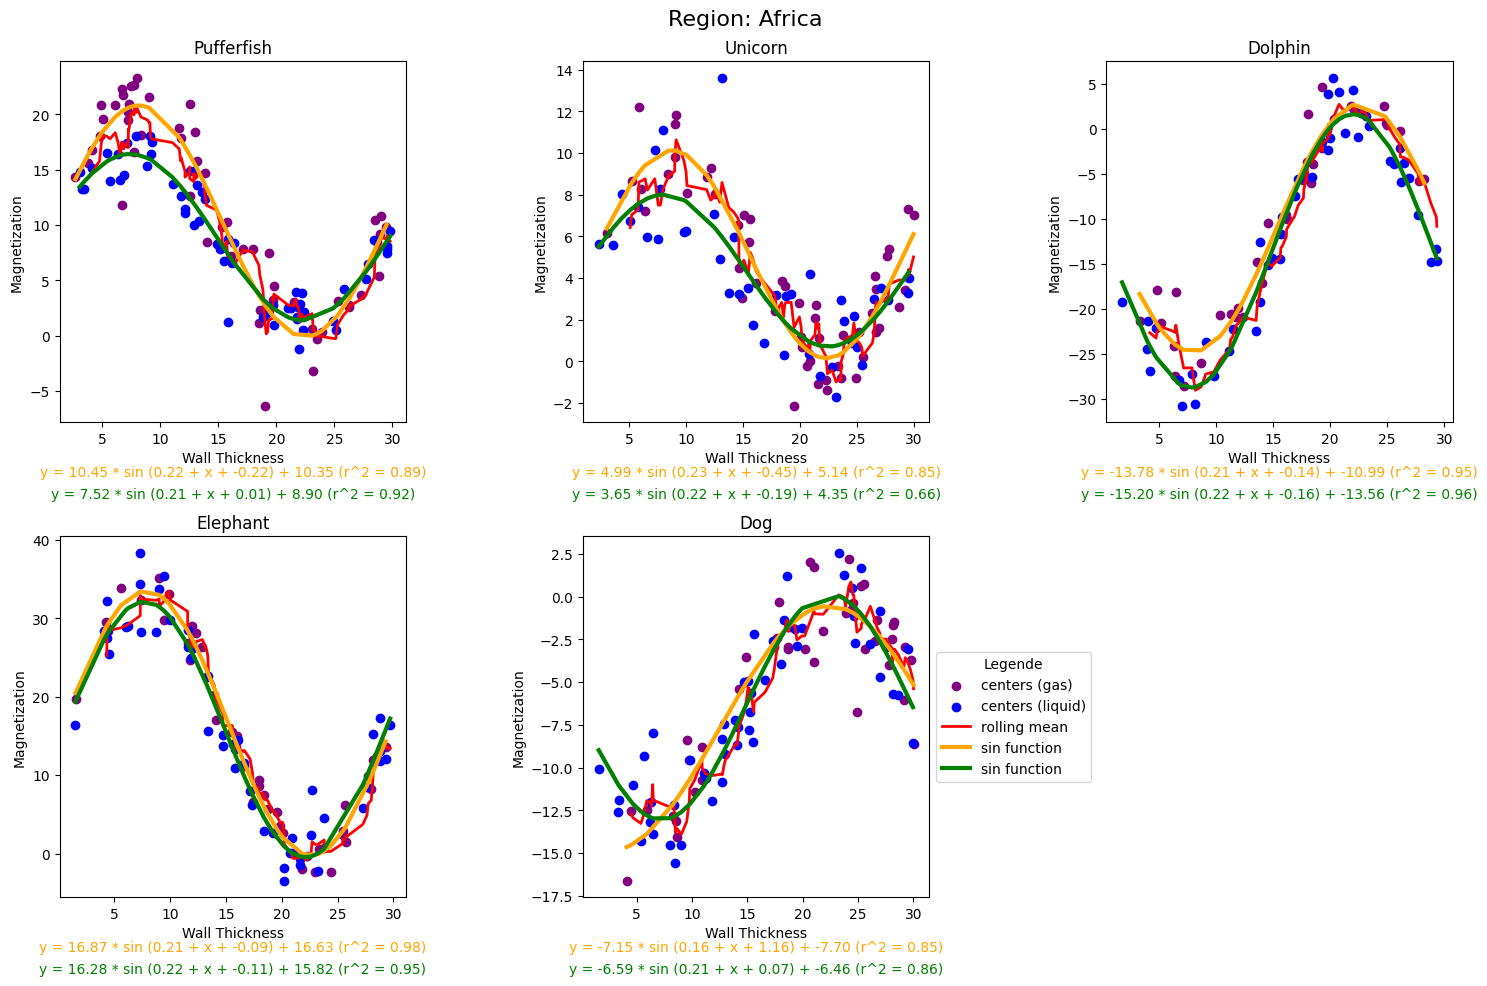

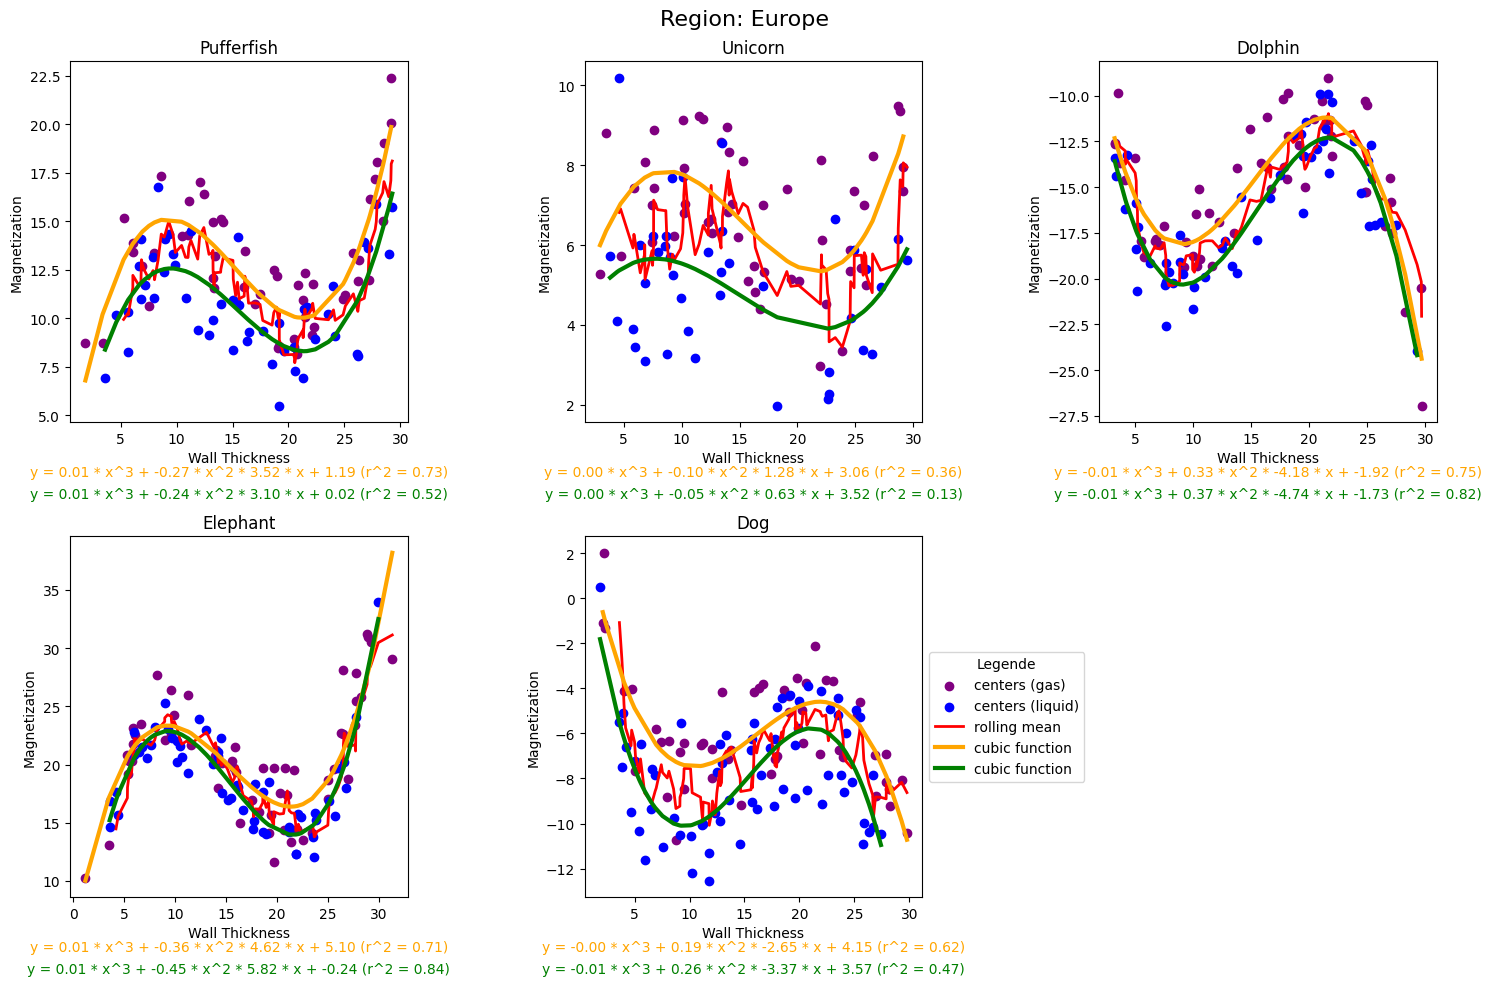

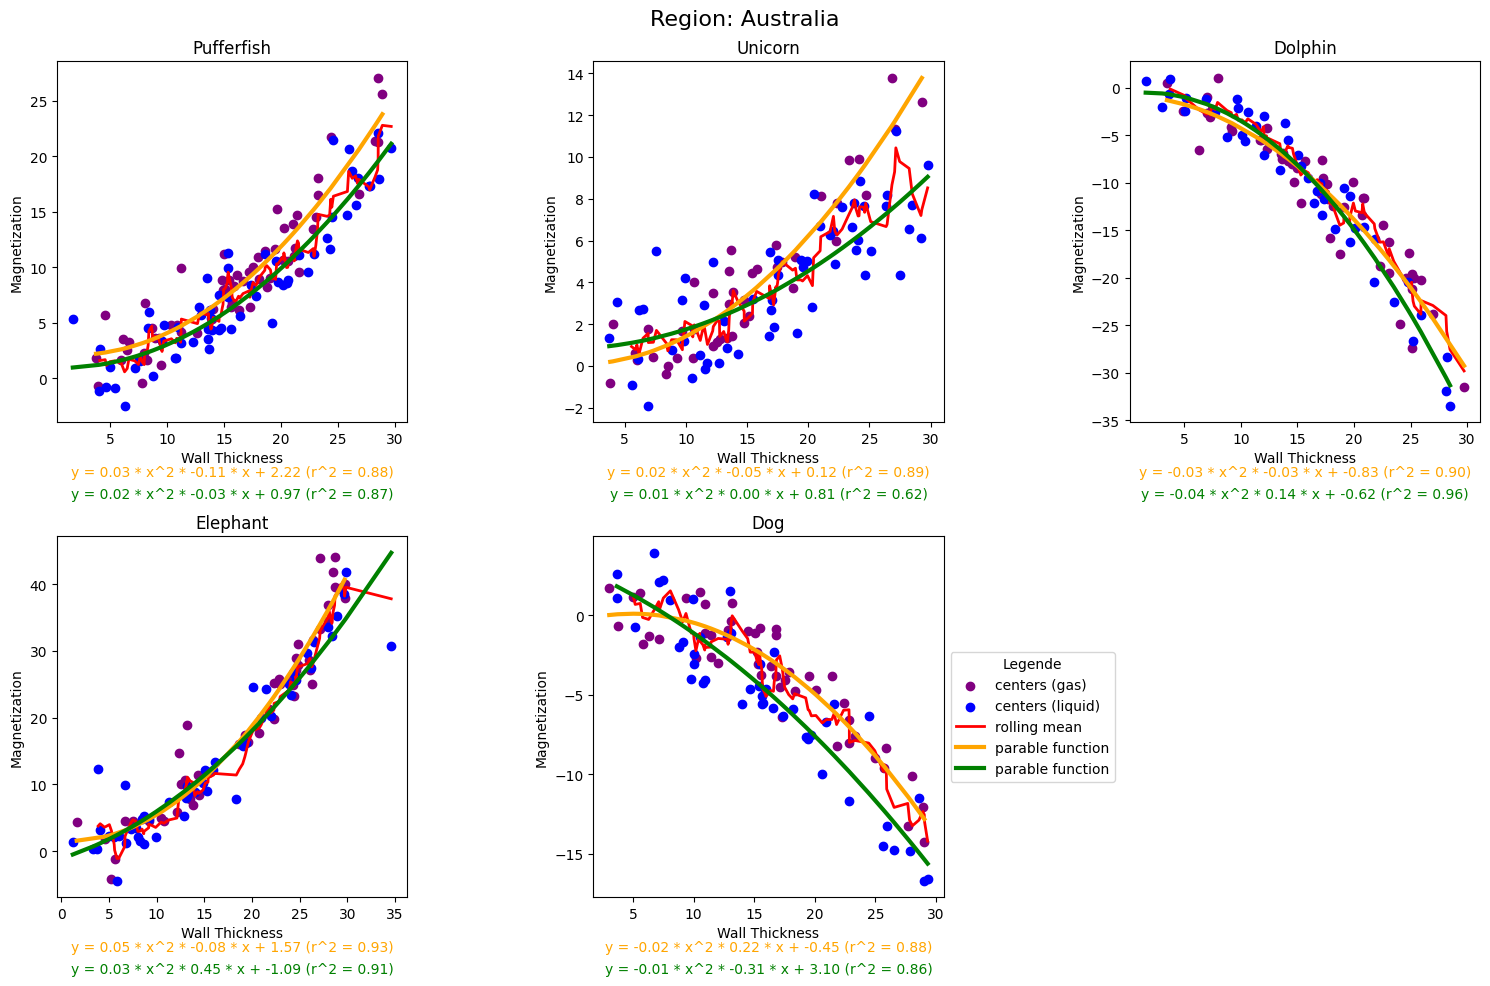

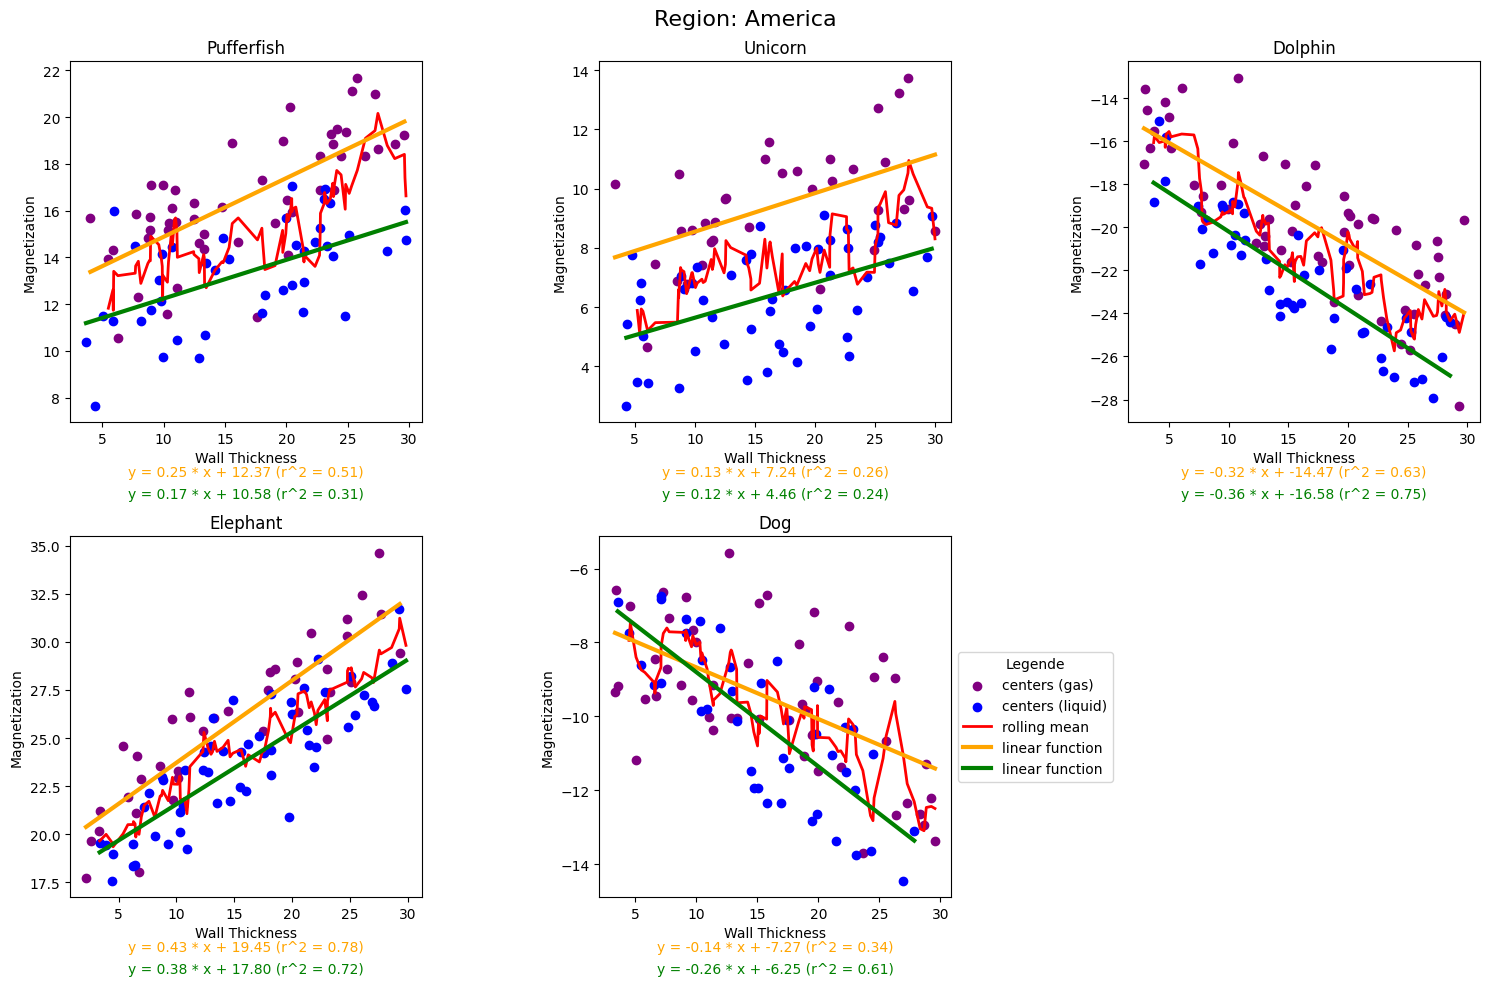

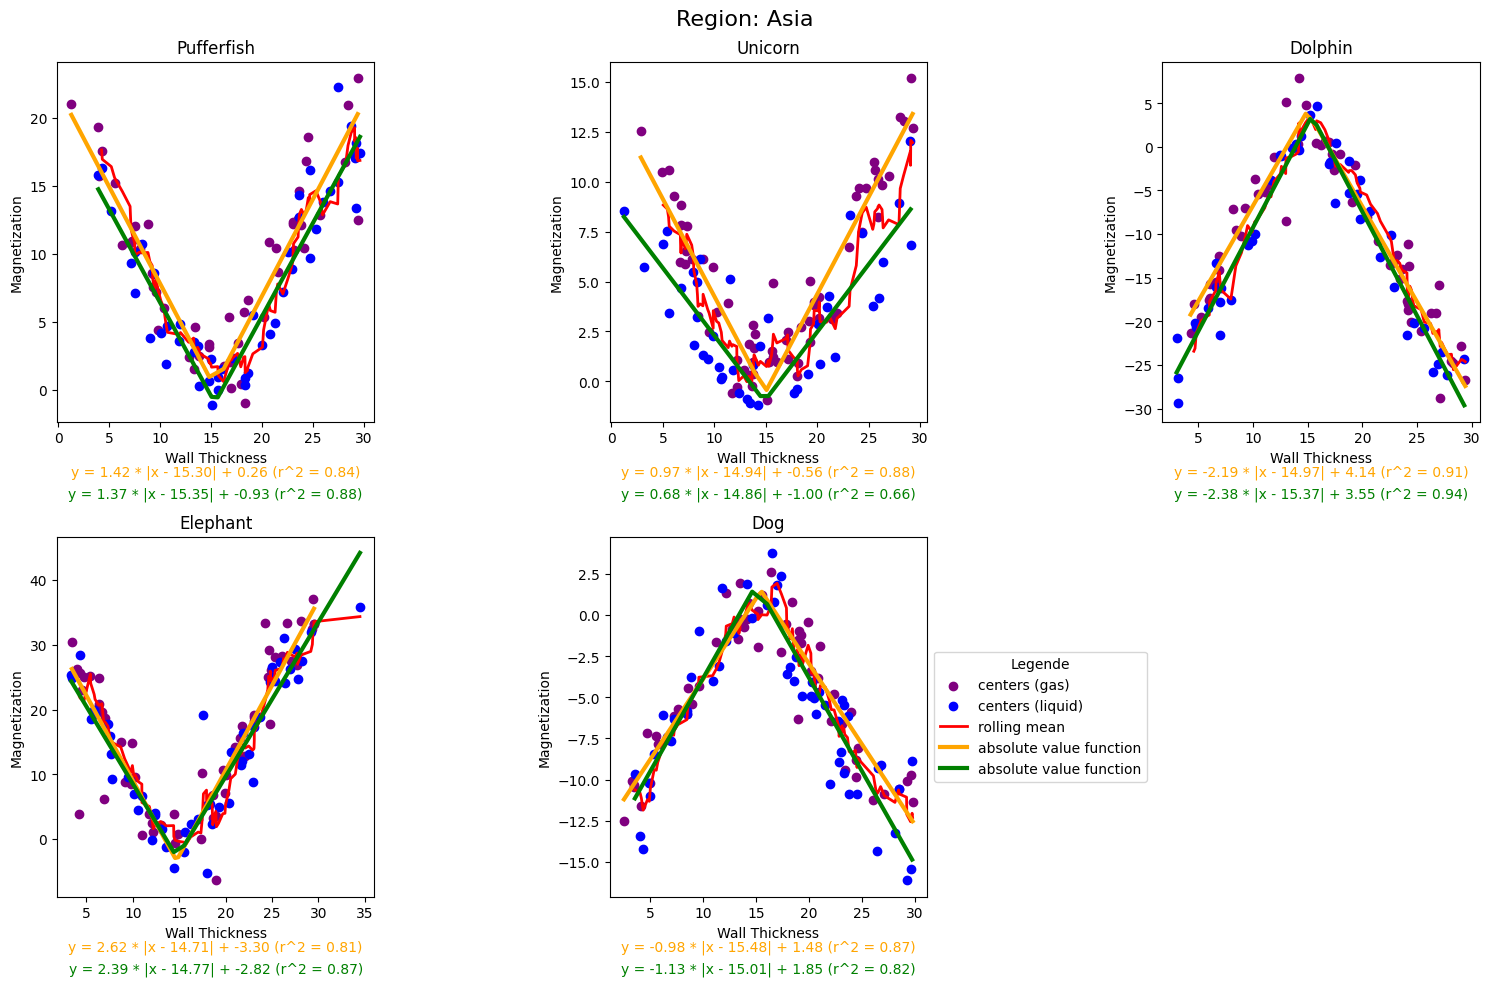

In [180]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

files.sort_values(by=["configuration", "instrument"])

for configuration in files["configuration"].unique():

    dfs = {}
    
    rows = 2
    cols = 3
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))
    
    # filter only by instrument, configuration currently not distinguished
    for index, name in enumerate(files["instrument"].unique()):
        temp_df = files[files["configuration"] == configuration]
        temp_df = temp_df[temp_df["instrument"] == name]
    
        temp_df = temp_df.apply(prepare_data, axis=1, args=[False])
        
        array_wall_thickness = np.concatenate(temp_df["wall_thickness"].values)
        array_magnetization = np.concatenate(temp_df["magnetization"].values)
        array_velocity = np.concatenate(temp_df["velocity"].values)
        array_centers = np.concatenate(temp_df["centers"].values)
        if len(array_centers) == 0:
            continue
        d = pd.DataFrame(array_centers)
    
        
        #bad inf fix
        d.replace([np.inf, -np.inf], np.nan, inplace=True)
        d.dropna(how="all", inplace=True)
        
        d.columns = ["wall_thickness", "magnetization", "velocity"]
        
        #display(f"centers used: {d["magnetization"].count()}")
        #d.plot(kind="scatter", x="wall_thickness", y="magnetization", title=f"center plot {name}", xlim=(0,40), ylim=(-10, 10))
    
        d.sort_values(by="wall_thickness", inplace=True)
        
        #remove outlier
        outliers = zscore_create_outliers_mask(d["magnetization"], 3)
        outliers_wt = zscore_create_outliers_mask(d["wall_thickness"], 3)
        d = d[outliers & outliers_wt]
        d = d[d["wall_thickness"] < 40]
        d = d[d["wall_thickness"] > 1]
        d = d[d["magnetization"] != 0]
        d = d[d["magnetization"] < 100]
        d = d[d["velocity"] > 0]
        
        #vel test
        #display(d.head())
        #TODO
        #d["magnetization"] = d["magnetization"] - d["velocity"]
        
        #dbscan remove outlier
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(d[['wall_thickness', 'magnetization']])
        dbscan = DBSCAN(eps=0.8, min_samples=4)
        clusters = dbscan.fit_predict(scaled_features)
        d = d[clusters != -1]
        #---------
        
        row = index // cols
        col = index % cols
        ax = axes[row, col]
        
        
        init_params = []
        func = None
        if configuration == "Europe":
            func = cubic_func
            init_params = [5, 0.3, -1.5, -10]
            fname = "cubic function"
        elif configuration == "Asia":
            func = abs_func
            init_params = [10, 20, 0] 
            fname = "absolute value function"
        elif configuration == "Australia":
            func = quad_func
            init_params = [1, 1, 1]
            fname = "parable function"
        elif configuration == "Africa":
            func = sin_func
            init_params = [5, 0.3, -1.5, -10]
            fname = "sin function"
        elif configuration == "America":
            func = lin_func
            init_params = [1, 1]
            d = d[d["wall_thickness"] > 1]
            fname = "linear function"
    
        
        if func is not None:
            if True:
                d_gas = d[d["velocity"] >= 2.5]
                d_liq = d[d["velocity"] < 2.5]
            
                ax.scatter(d_gas['wall_thickness'], d_gas['magnetization'], label='centers (gas)', c="purple")
                ax.scatter(d_liq['wall_thickness'], d_liq['magnetization'], label='centers (liquid)', c="blue")
                ax.plot(d['wall_thickness'], d["magnetization"].rolling(5).mean(), label='rolling mean', color='red', linewidth=2)
                [params, covariance] = curve_fit(func, d_gas["wall_thickness"], d_gas["magnetization"], init_params)
                predict = func(d_gas["wall_thickness"], *params)
                r_squared = r2_score(d_gas["magnetization"], predict)
                ax.plot(d_gas['wall_thickness'], predict, label=fname, color='orange', linewidth=3)
                
                            
                if configuration == "Europe":
                    title = f"y = {params[0]:.2f} * x^3 + {params[1]:.2f} * x^2 * {params[2]:.2f} * x + {params[3]:.2f}"
                elif configuration == "Asia":
                    title = f"y = {params[0]:.2f} * |x - {params[1]:.2f}| + {params[2]:.2f}"
                elif configuration == "Australia":
                    title = f"y = {params[0]:.2f} * x^2 * {params[1]:.2f} * x + {params[2]:.2f}"
                elif configuration == "Africa":
                    title = f"y = {params[0]:.2f} * sin ({params[1]:.2f} + x + {params[2]:.2f}) + {params[3]:.2f}"
                elif configuration == "America":
                    title = f"y = {params[0]:.2f} * x + {params[1]:.2f}"
                    
                title += f" (r^2 = {r_squared:.2f})"
                
                ax.text(0.5, -0.12, title, ha='center', va='top', transform=ax.transAxes, color="orange")  
                
                [params, covariance] = curve_fit(func, d_liq["wall_thickness"], d_liq["magnetization"], init_params)
                predict = func(d_liq["wall_thickness"], *params)
                r_squared = r2_score(d_liq["magnetization"], predict)
                ax.plot(d_liq['wall_thickness'], predict, label=fname, color='green', linewidth=3)
                
                
                if configuration == "Europe":
                    title = f"y = {params[0]:.2f} * x^3 + {params[1]:.2f} * x^2 * {params[2]:.2f} * x + {params[3]:.2f}"
                elif configuration == "Asia":
                    title = f"y = {params[0]:.2f} * |x - {params[1]:.2f}| + {params[2]:.2f}"
                elif configuration == "Australia":
                    title = f"y = {params[0]:.2f} * x^2 * {params[1]:.2f} * x + {params[2]:.2f}"
                elif configuration == "Africa":
                    title = f"y = {params[0]:.2f} * sin ({params[1]:.2f} + x + {params[2]:.2f}) + {params[3]:.2f}"
                elif configuration == "America":
                    title = f"y = {params[0]:.2f} * x + {params[1]:.2f}"
                    
                title += f" (r^2 = {r_squared:.2f})"
                
                
                ax.text(0.5, -0.18, title, ha='center', va='top', transform=ax.transAxes, color="green")
                
            
            else:
                ax.scatter(d['wall_thickness'], d['magnetization'], label='centers', c="blue")
                ax.plot(d['wall_thickness'], d["magnetization"].rolling(5).mean(), label='rolling mean', color='red', linewidth=2)
                [params, covariance] = curve_fit(func, d["wall_thickness"], d["magnetization"], init_params)
                predict = func(d["wall_thickness"], *params)
                r_squared = r2_score(d["magnetization"], predict)
                ax.plot(d['wall_thickness'], predict, label=fname, color='green', linewidth=3)
                if configuration == "Europe":
                    title = f"y = {params[0]:.2f} * x^3 + {params[1]:.2f} * x^2 * {params[2]:.2f} * x + {params[3]:.2f}"
                elif configuration == "Asia":
                    title = f"y = {params[0]:.2f} * |x - {params[1]:.2f}| + {params[2]:.2f}"
                elif configuration == "Australia":
                    title = f"y = {params[0]:.2f} * x^2 * {params[1]:.2f} * x + {params[2]:.2f}"
                elif configuration == "Africa":
                    title = f"y = {params[0]:.2f} * sin ({params[1]:.2f} + x + {params[2]:.2f}) + {params[3]:.2f}"
                elif configuration == "America":
                    title = f"y = {params[0]:.2f} * x + {params[1]:.2f}"
                    
                title += f" (r^2 = {r_squared:.2f})"
                
                ax.text(0.5, -0.12, title, ha='center', va='top', transform=ax.transAxes, color="green")  
        
    
        #plt.figtext(0.5, 0.01, 'Dies ist ein erläuternder Text unter dem Plot.', ha='center', va='bottom')
        ax.set_title(name)
        ax.set_xlabel('Wall Thickness')
        ax.set_ylabel('Magnetization')
    
    
    if 5 < rows * cols:
        for idx in range(5, rows * cols):
            fig.delaxes(axes.flatten()[idx])
            
            
    plt.legend(title="Legende", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    plt.suptitle(f"Region: {configuration}", fontsize=16)
    plt.tight_layout()
    plt.show()
    

In [29]:
for instrument, df in dfs.items():
    display(instrument)
    #display(df.plot(kind="scatter", x="wall_thickness", y="magnetization", xlim=(0, 40), ylim=(0, 40)))
    
    fig = plt.figure()
    ax = fig.add_subplot()
    
    x = df['wall_thickness']
    y = df['magnetization']
    z = np.zeros(len(df)) 
    #c = np.abs(df['velocity'])
    
    ax.scatter(x, y, c=c, cmap='viridis')
    
    ax.set_xlabel('Wall Thickness')
    ax.set_ylabel('Magnetization (corrected)')
    ax.set_title('Wall Thickness vs. Corrected Magnetization with Velocity as Third Dimension')
    
    

hier ist wahrscheinlich irgendwo der effekt mit den "langgezogenen punktwolken" aufgrund der abnutzung der kontakte drin

In [ ]:
files.head()